In [1]:
import os
import b3d
import jax.numpy as jnp
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


In [2]:
# paths for reading physion metadata
physion_assets_path = '/home/haoliangwang/data/physion_hdf5/collide_all_movies'

stim_name = 'pilot_it2_collision_non-sphere_box_0015'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

video_file_path = os.path.join(physion_assets_path,
    f"{stim_name}_img.mp4",
)

In [6]:
# def compute_angular_velocity(q1, q2, dt):
#     return (2 / dt) * np.array([
#         q1[0]*q2[1] - q1[1]*q2[0] - q1[2]*q2[3] + q1[3]*q2[2],
#         q1[0]*q2[2] + q1[1]*q2[3] - q1[2]*q2[0] - q1[3]*q2[1],
#         q1[0]*q2[3] - q1[1]*q2[2] + q1[2]*q2[1] - q1[3]*q2[0]])

def compute_angular_velocity(q1, q2, delta_t):
    """
    Compute angular velocity in radians per second from two quaternions.

    Parameters:
        q1 (array-like): Quaternion at the earlier time [w, x, y, z].
        q2 (array-like): Quaternion at the later time [w, x, y, z].
        delta_t (float): Time difference between the two quaternions.

    Returns:
        angular_velocity (numpy array): Angular velocity vector (radians per second).
    """
    # Convert quaternions to scipy Rotation objects
    rot1 = R.from_quat(q1)
    rot2 = R.from_quat(q2)
    
    # Compute the relative rotation
    relative_rotation = rot2 * rot1.inv()
    
    # Convert the relative rotation to angle-axis representation
    angle = relative_rotation.magnitude()  # Rotation angle in radians
    axis = relative_rotation.as_rotvec() / angle if angle != 0 else np.zeros(3)  # Rotation axis
    
    # Compute angular velocity
    angular_velocity = (axis * angle) / delta_t
    return angular_velocity


In [7]:

# Example usage
q1 = [0.7071, 0, 0.7071, 0]  # Quaternion at time t1
q2 = [1, 0, 0, 0]            # Quaternion at time t2
delta_t = 0.1                # Time difference in seconds

angular_velocity = compute_angular_velocity(q1, q2, delta_t)
print("Angular Velocity (radians per second):", angular_velocity)

Angular Velocity (radians per second): [ 0.         15.70796327  0.        ]


In [21]:
# fps = b3d.io.utils.load_video_info(video_file_path).fps
fps = 100
delta_t = 1/fps
obj_idx = 3

recorded = []
computed = []
with h5py.File(hdf5_file_path, "r") as f:
    for key in f['frames'].keys():
        ang_vel = jnp.array(f['frames'][key]['objects']['angular_velocities'])
        quaternion_now = jnp.array(f['frames'][key]['objects']['rotations_cam0'])
        # print(ang_vel.shape, quaternion_now.shape)
        if key == '0000':
            continue
        frame_idx = int(key)
        quaternion_last = jnp.array(f['frames'][str(frame_idx-1).zfill(4)]['objects']['rotations_cam0'])
        angular_velocity = compute_angular_velocity(quaternion_last[obj_idx], quaternion_now[obj_idx], delta_t)
        # angular_velocity = np.dot(angular_velocity, np.array([[0,0,1],[0,-1,0],[-1,0,0]]))
        recorded.append(ang_vel[obj_idx])
        computed.append(angular_velocity)
        # print("Angular Velocity computed:", angular_velocity)
        # print("Angular Velocity recorded:", ang_vel[obj_idx], '\n')

In [22]:
recorded = np.array(recorded)
computed = np.array(computed)

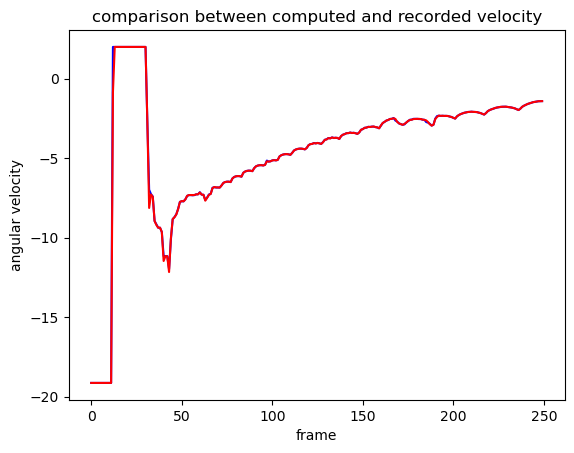

: 

In [ ]:
dim = 2

frames = [i for i in range(computed[:,0].shape[0])]

plt.plot(frames, recorded[:,dim], 'blue')
plt.plot(frames, computed[:,dim], 'red')
plt.xlabel("frame")
plt.ylabel("angular velocity")
plt.title('comparison between computed and recorded velocity')
plt.show()
